<a href="https://colab.research.google.com/github/aminsarzaeem/deep/blob/main/VAE_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: MohammadAmin Sarzaeem
### Student ID: 402207082

# Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 125881339.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 12952918.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39170870.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3349249.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

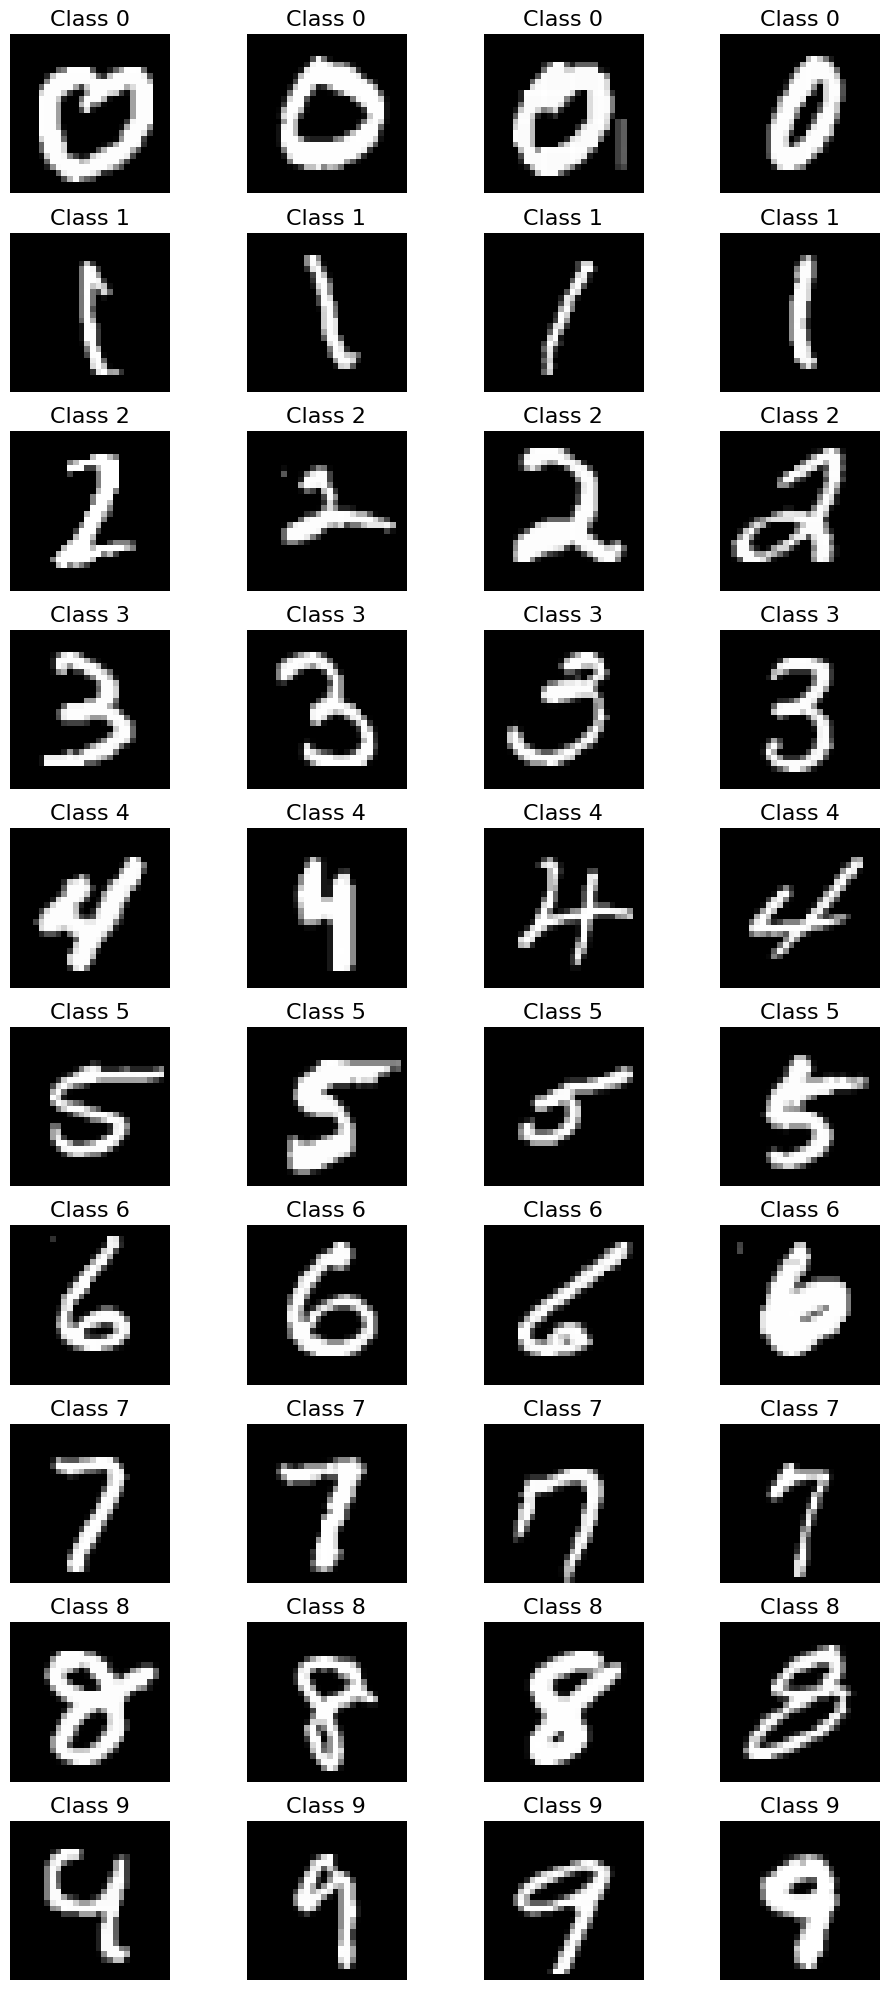

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [ ]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # 2 layer encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            # 2 layer deccoder
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        z = torch.randn(mu.shape, device = mu.device)
        return mu + torch.exp(logvar/2)* z

    def forward(self, x):
        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        Mu = self.fc_mu(hidden)
        Logvar = self.fc_logvar(hidden)
        latent = self.reparameterize(Mu, Logvar)
        out = self.decoder(latent)
        return out, (Mu, Logvar)
        pass

In [ ]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5*torch.sum(torch.exp(logvar**2)+mu**2-1-logvar)

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [ ]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process

            # TODO: Flatten the data and recon tensors
            data = data.view(-1,28*28)
            recon, (mu, logvar) = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss/len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict() # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'drive/My Drive/Colab Notebooks/deep/best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 12496.092112852311
Sample Images:


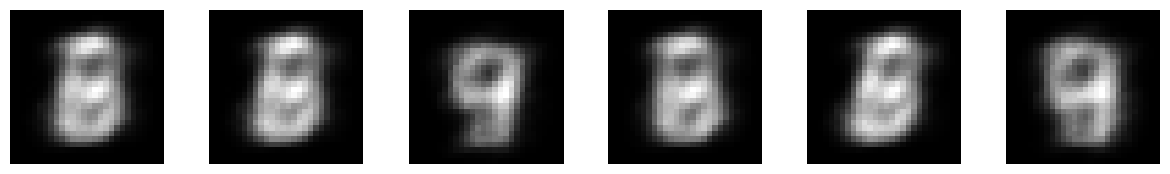


##################################################
VAE-MLP Epoch [2/10], Loss: 11170.848833747
Sample Images:


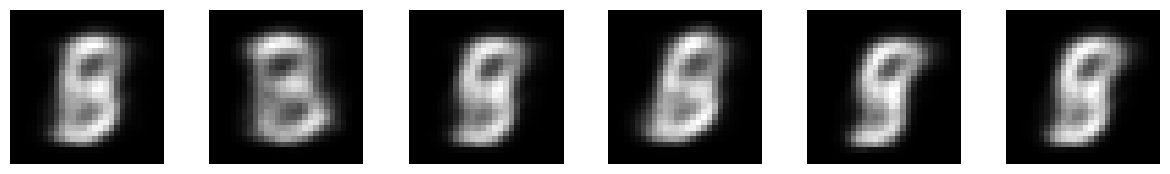


##################################################
VAE-MLP Epoch [3/10], Loss: 11004.144083051538
Sample Images:


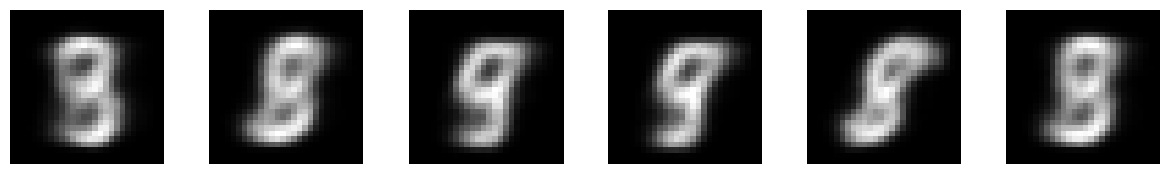


##################################################
VAE-MLP Epoch [4/10], Loss: 10882.048961907816
Sample Images:


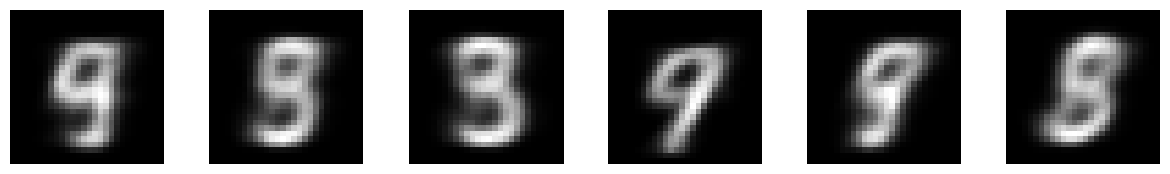


##################################################
VAE-MLP Epoch [5/10], Loss: 10810.739094878565
Sample Images:


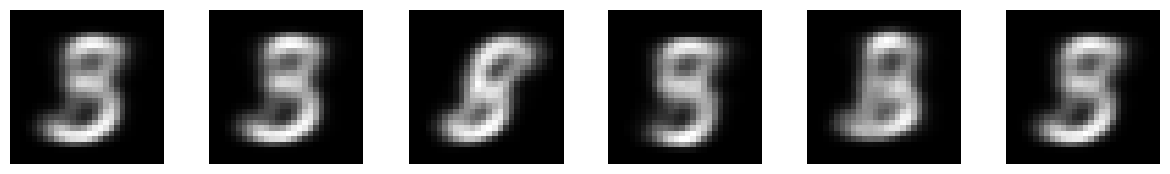


##################################################
VAE-MLP Epoch [6/10], Loss: 10754.761132083722
Sample Images:


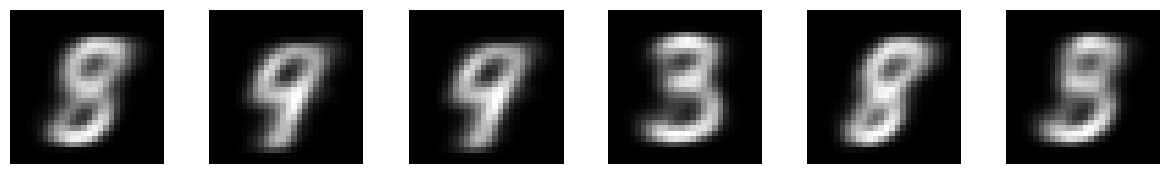


##################################################
VAE-MLP Epoch [7/10], Loss: 10710.293393002898
Sample Images:


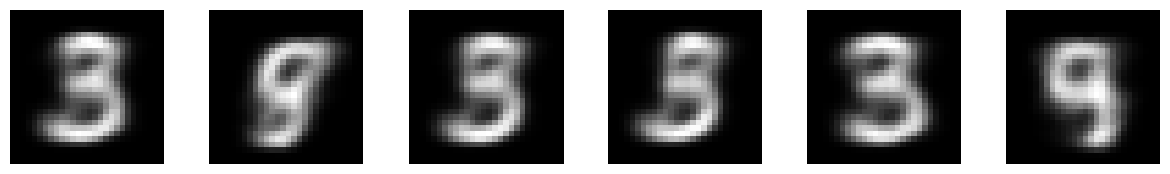


##################################################
VAE-MLP Epoch [8/10], Loss: 10681.95332853728
Sample Images:


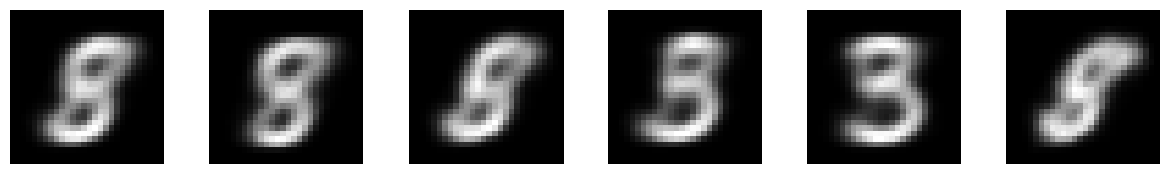


##################################################
VAE-MLP Epoch [9/10], Loss: 10654.448830415446
Sample Images:


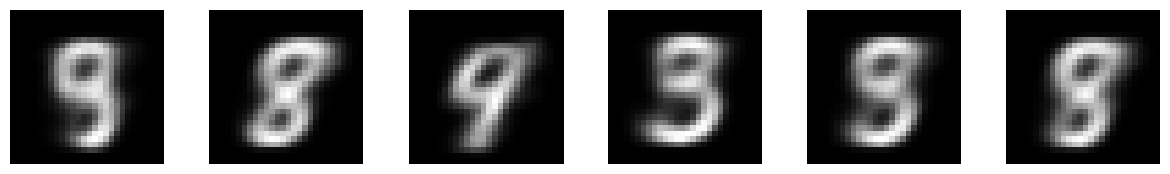


##################################################
VAE-MLP Epoch [10/10], Loss: 10625.71552723964
Sample Images:


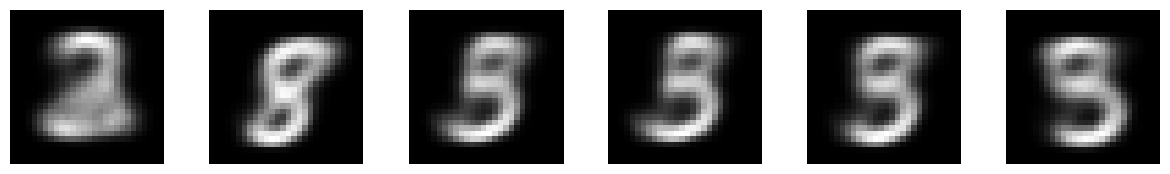

RuntimeError: Parent directory drive/My Drive/Colab Notebooks/deep does not exist.

In [ ]:
# Train VAE-MLP
vae_mlp = VAE_MLP(28*28, 100, 2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            # 2 layer deccoder
            nn.Linear(latent_dim + num_classes , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        z = torch.randn(mu.shape, device = mu.device)
        return mu + torch.exp(logvar/2)* z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat((x,y), dim = 1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        Mu = self.fc_mu(hidden)
        Logvar = self.fc_logvar(hidden)
        latent = self.reparameterize(Mu, Logvar)
        class_logits = self.fc_class(latent)

        reconstructed = self.decoder(torch.cat((z, y), dim= 1))

        return reconstructed, mu, logvar, class_logits
        hidden = None
        mu = None
        logvar = None
        z = None
        class_logits = None

        reconstructed = None

        return reconstructed, mu, logvar, class_logits


In [ ]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = None

    # TODO: Implement the reconstruction loss
    reconstruction_loss = None

    # TODO: Implement the KL divergence loss
    kl_divergence = None

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = None

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return None


In [ ]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = None

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon = None
            mu = None
            logvar = None
            class_logits = None
            loss = None

            # TODO: Backpropagation and optimization step
            None

            total_loss = None

        avg_loss = None
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 20)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = None

    # TODO: Save the best model to a file
    None
    print("Best model saved as 'best_cvae_mlp_model.pth'")


In [ ]:
cvae_mlp = None
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).
